ALS 추천을 이커머스 데이터에 적용시킨 사례입니다.

코드 (https://gist.github.com/himanshk96/21594b9f49a8b3060ff1f00d0a0d8ec5)

데이터 (https://www.kaggle.com/retailrocket/ecommerce-dataset)


In [1]:
#import libraries
import sys
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random



from sklearn.preprocessing import MinMaxScaler

import implicit 
from datetime import datetime, timedelta


- 데이터 전처리

In [2]:

#Data Preprocessing
def create_data(datapath,start_date,end_date):
    df=pd.read_csv(datapath)
    df=df.assign(date=pd.Series(datetime.fromtimestamp(a/1000).date() for a in df.timestamp))
    df=df.sort_values(by='date').reset_index(drop=True) # for some reasons RetailRocket did NOT sort data by date
    df=df[(df.date>=datetime.strptime(start_date,'%Y-%m-%d').date())&(df.date<=datetime.strptime(end_date,'%Y-%m-%d').date())]
    df=df[['visitorid','itemid','event']]
    return df

지정해준 날짜 사이의 visitorid, itemid, event 칼럼을 뽑아옵니다.

In [3]:
#Download the kaggle RetailRocket data and give the events.csv file path
datapath= '../input/ecommerce-dataset/events.csv'
data=create_data(datapath,'2015-5-3','2015-5-18')

In [4]:
data

,visitorid,itemid,event
0,689859,421640,view
1,935582,203248,view
2,696326,194830,view
3,131668,395045,view
4,595484,129111,view
...,...,...,...
323398,98071,127688,view
323399,802445,269981,view
323400,1217864,338788,view
323401,506257,425157,view


In [5]:
data.event.value_counts()

view           312674
addtocart        8080
transaction      2649
Name: event, dtype: int64

event 칼럼엔 (view, addtocart, transaction) 세가지 값이 들어있습니다. 

In [7]:
data['visitorid'] = data['visitorid'].astype("category")
data['itemid'] = data['itemid'].astype("category")

In [11]:
data.head()

,visitorid,itemid,event
0,689859,421640,view
1,935582,203248,view
2,696326,194830,view
3,131668,395045,view
4,595484,129111,view


In [16]:
print('아이템 고유값 : ',data.itemid.nunique())
print('방문자 고유값 : ',data.visitorid.nunique())

아이템 고유값 :  82358
방문자 고유값 :  169613


In [18]:
data['visitor_id'] = data['visitorid'].cat.codes
data['item_id'] = data['itemid'].cat.codes
data['event']=data['event'].astype('category')
data['event']=data['event'].cat.codes

희소행렬을 만들기 위해 데이터 프레임의 방문자, 아이템, 이벤트 칼럼의 고유값으로 값을 매칭시켜줍니다.

In [19]:
data.head()

,visitorid,itemid,event,visitor_id,item_id
0,689859,421640,2,83166,74466
1,935582,203248,2,112824,35772
2,696326,194830,2,83964,34280
3,131668,395045,2,15852,69798
4,595484,129111,2,71747,22761


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323403 entries, 0 to 323402
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   visitorid   323403 non-null  category
 1   itemid      323403 non-null  category
 2   event       323403 non-null  int8    
 3   visitor_id  323403 non-null  int32   
 4   item_id     323403 non-null  int32   
dtypes: category(2), int32(2), int8(1)
memory usage: 17.1 MB


희소행렬 만들기

In [23]:
import scipy.sparse as sparse


In [24]:
sparse_item_user = sparse.csr_matrix((data['event'].astype(float), (data['item_id'], data['visitor_id'])))
sparse_user_item = sparse.csr_matrix((data['event'].astype(float), (data['visitor_id'], data['item_id'])))

In [25]:
sparse_item_user

<82358x169613 sparse matrix of type '<class 'numpy.float64'>'
	with 251957 stored elements in Compressed Sparse Row format>

In [26]:
sparse_user_item

<169613x82358 sparse matrix of type '<class 'numpy.float64'>'
	with 251957 stored elements in Compressed Sparse Row format>

### ALS 모델

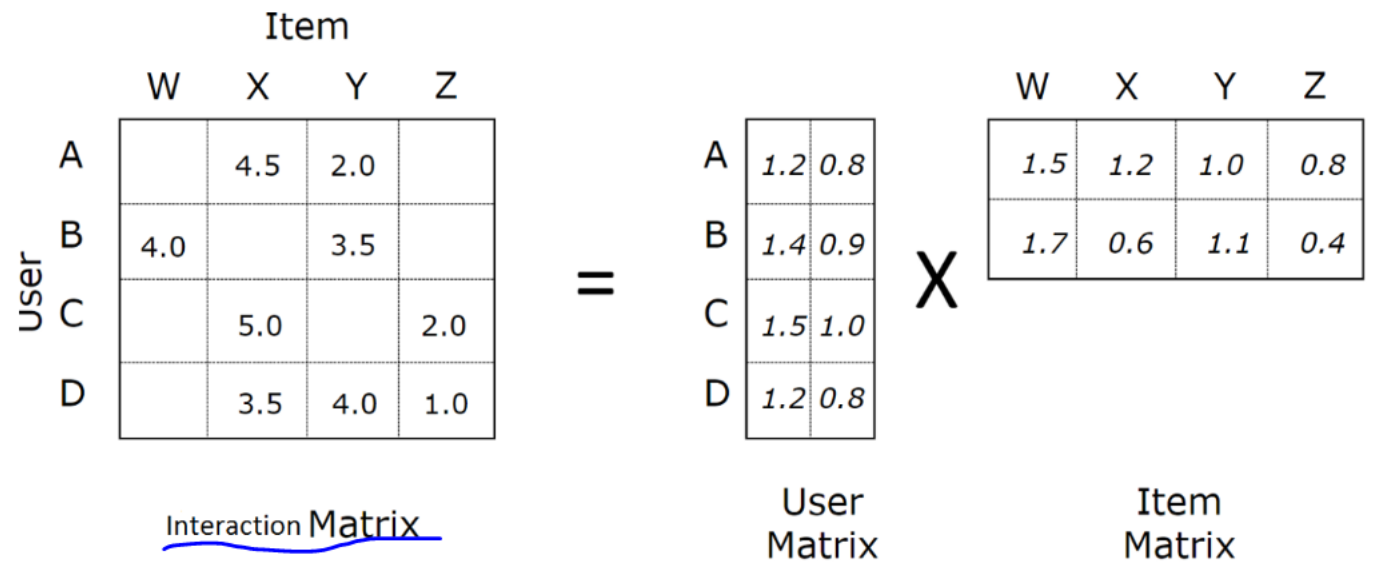

In [4]:
from IPython.display import Image
Image("image/als_1.png") 

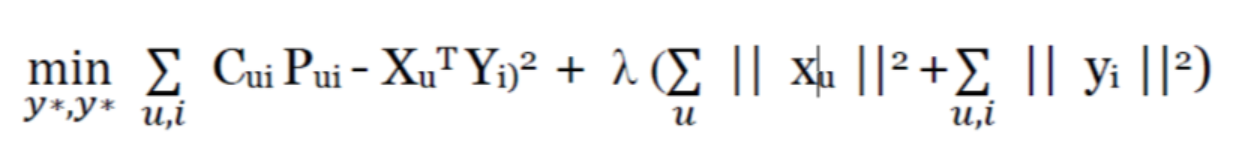

In [5]:
from IPython.display import Image
Image("image/als_2.png") 

위식은 손실 함수입니다. 이때, Cui는 confidence항, Pui는 Preference항, 감마는 오버피팅 방지를 위한 정규화항입니다.

ALS 알고리즘을 사용하여, User Matrix, Item matrix를 번갈아 가며 최적화시킵니다. (하나를 상수로 보고 나머지를 최적화시키는 방식) 



In [38]:
#Building the model
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)


잠재인수를 20, 정규항(감마)을 0.1, 20번 반복시키며 오차를 줄여나가는 모델

In [40]:
alpha_val = 40
data_conf = (sparse_item_user * alpha_val).astype('double') # 학습할때는 아이템_유저 메트릭스로 학습시킨다!

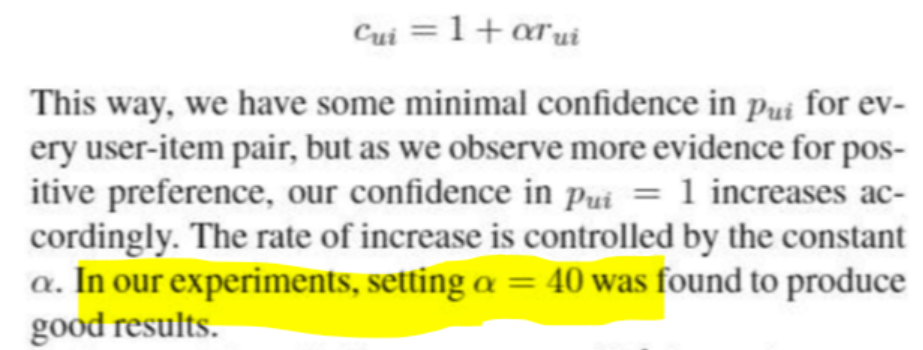

In [7]:
from IPython.display import Image
Image("image/als_3.png") 
# Collaborative Filtering for implicit Feedback Datasets



Cui항은 해당 데이터의 신뢰도를 나타넵니다. 영화 평점 데이터와 같이 explicit한 데이터에선 평점이 없는경우, 평점이 남아있지 않은 데이터는 모두 0으로 바꾸어주지만, 이 논문에서는 이 신뢰도 변수를 도입하여 평점이 남아있지 않은 데이터에 대한 예측값도 Loss Function에 영향을 주도록 만들었습니다.

In [41]:
data_conf

<82358x169613 sparse matrix of type '<class 'numpy.float64'>'
	with 251957 stored elements in Compressed Sparse Row format>

In [42]:
model.fit(data_conf)

implicit 공식 문서에 있는 패키지 사용방법 (출처 : https://implicit.readthedocs.io/en/latest/quickstart.html#basic-usage)



In [49]:
###USING THE MODEL

#Get Recommendations
user_id =   14
recommended = model.recommend(user_id, sparse_user_item, N = 10) # 추천을 할때는 user_item 메트릭스를 사용한다!
print(recommended)

[(63041, 0.00010895458), (17939, 0.000107543616), (6489, 0.00010653283), (63267, 0.000102652484), (19957, 0.000101421785), (81791, 9.7583295e-05), (56403, 9.3711984e-05), (36966, 9.036528e-05), (53765, 8.942916e-05), (77367, 8.893129e-05)]


추천의 개수는 recommend 메서드의 N 파라미터로 조정합니다.

In [51]:
# visitor_id 14가 보았던 아이템
data[data.visitor_id == 14]

,visitorid,itemid,event,visitor_id,item_id
143371,99,158848,2,14,27992
144022,99,158848,2,14,27992


비슷한 아이템 추출은 similar_items 메서드를 활용합니다.

In [48]:
#Get similar items
item_id = 7
n_similar = 4
similar = model.similar_items(item_id, n_similar)
print(similar)

[(7, 0.022274008), (34915, 0.022235239), (37901, 0.022018855), (42460, 0.021635007)]


비슷한 사용자는 similar_users() 메서드로 추출합니다.

In [55]:

user_id = 14
n_similar = 4

similar_user = model.similar_users(user_id, n_similar)
print(similar_user)

[(14, 0.0009446156), (47594, 0.00094313483), (98464, 0.00094313483), (20988, 0.0009427666)]


이외에도 implicit 패키지는 추천에 대한 설명을 해주는 메서드, 특정 사용자에 대한 추천 아이템 순위를 보여주는 메서드, 모든 유저에 대한 추천 아이템을 보여주는 메서드등을 제공합니다. 자세한 내용은 아래의 공식문서에서 확인하시면 됩니다. 감사합니다.

https://implicit.readthedocs.io/en/latest/als.html